In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2016-08-23'
end_date = '2017-08-23'

temp = [ct for ct in calc_temps(start_date, end_date)[0]]
temp

[58.0, 74.59058295964125, 87.0]

<ErrorbarContainer object of 3 artists>

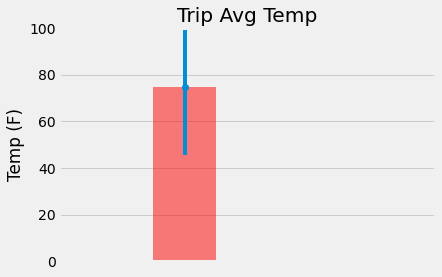

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
plt.bar(1, temp[1], color='r', width = 0.2, alpha=0.5, align="center")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(0.6,1.8)
plt.ylim(0,100)
ax.axes.xaxis.set_visible(False)
ax.errorbar(1, temp[1], temp[2] - temp[0], fmt="o")

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def total_rainfall(start_date, end_date):
    sel = [Measurement.date, func.sum(Measurement.prcp),
           Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
    
    return session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

In [13]:
total_rainfall(start_date, end_date)

[('2016-08-23', 147.81000000000006, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('2016-08-23', 70.03000000000003, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('2016-08-23', 48.510000000000026, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('2016-08-23', 38.01, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('2016-08-23', 33.239999999999995, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('2016-08-23', 16.089999999999986, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('2016-08-23', 4.59, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# # Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

trip_dates=pd.date_range(start_date,end_date)
trip_dates

DatetimeIndex(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06', '2017-08-07'],
              dtype='datetime64[ns]', freq='D')

In [16]:
# Strip off the year and save a list of strings in the format %m-%d
newdf=trip_dates.strftime('%m-%d')
print(f"{newdf}")

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')


In [36]:
normals = []
for date in newdf:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [38]:
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


Text(0, 0.5, 'Temp (F)')

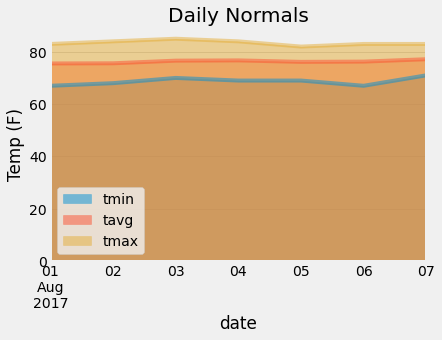

In [39]:
df.plot.area(stacked = False)
plt.title("Daily Normals")
plt.ylabel("Temp (F)")

## Close Session

In [ ]:
session.close()